In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import roc_curve, auc, accuracy_score,precision_score, recall_score, roc_auc_score, f1_score,classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_colwidth', 1000, 'display.max_rows', None, 'display.max_columns', None)
%matplotlib inline
mpl.style.use('ggplot')
sns.set(style='whitegrid')

## 1. Data

In [2]:
df = pd.read_stata("lendingclub.dta")

In [3]:
df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens,emp_length1,emp_length2,emp_length3,emp_length4,emp_length5,emp_length6,emp_length7,emp_length8,emp_length9,emp_length10,emp_length11,emp_length12,home_ownership1,home_ownership2,home_ownership3,home_ownership4,home_ownership5,home_ownership6,verification_status1,verification_status2,verification_status3,purpose1,purpose2,purpose3,purpose4,purpose5,purpose6,purpose7,purpose8,purpose9,purpose10,purpose11,purpose12,purpose13,purpose14,addr_state1,addr_state2,addr_state3,addr_state4,addr_state5,addr_state6,addr_state7,addr_state8,addr_state9,addr_state10,addr_state11,addr_state12,addr_state13,addr_state14,addr_state15,addr_state16,addr_state17,addr_state18,addr_state19,addr_state20,addr_state21,addr_state22,addr_state23,addr_state24,addr_state25,addr_state26,addr_state27,addr_state28,addr_state29,addr_state30,addr_state31,addr_state32,addr_state33,addr_state34,addr_state35,addr_state36,addr_state37,addr_state38,addr_state39,addr_state40,addr_state41,addr_state42,addr_state43,addr_state44,addr_state45,addr_state46,addr_state47,addr_state48,addr_state49,addr_state50,addr_state51,initial_list_status1,initial_list_status2,elapsed_t,issue_d1,issue_d2,issue_d3,issue_d4,issue_d5,issue_d6,issue_d7,issue_d8,issue_d9,issue_d10,issue_d11,issue_d12,issue_d13,issue_d14,issue_d15,issue_d16,issue_d17,issue_d18,issue_d19,issue_d20,issue_d21,issue_d22,issue_d23,issue_d24,issue_d25,issue_d26,issue_d27,issue_d28,issue_d29,issue_d30,issue_d31,issue_d32,issue_d33,issue_d34,issue_d35,issue_d36,issue_d37,issue_d38,issue_d39,issue_d40,issue_d41,issue_d42,issue_d43,issue_d44,issue_d45,issue_d46,issue_d47,issue_d48,issue_d49,issue_d50,issue_d51,issue_d52,issue_d53,issue_d54,issue_d55,issue_d56,issue_d57,issue_d58,issue_d59,issue_d60,issue_d61,issue_d62,issue_d63,issue_d64,issue_d65,issue_d66,issue_d67,issue_d68,issue_d69,issue_d70,issue_d71,issue_d72,issue_d73,issue_d74,issue_d75,issue_d76,issue_d77,issue_d78,issue_d79,issue_d80,issue_d81,issue_d82,issue_d83,issue_d84,issue_d85,issue_d86,issue_d87,issue_d88,issue_d89,issue_d90,issue_d91,issue_d92,issue_d93,issue_d94,issue_d95,issue_d96,issue_d97,issue_d98,issue_d99,issue_d100,issue_d101,issue_d102,issue_d103,issue_d104,issue_d105,issue_d106,issue_d107,issue_d108,issue_d109,issue_d110,issue_d111,issue_d112,issue_d113,issue_d114,issue_d115,issue_d116,issue_d117,issue_d118,debt_settlement_flag1,term1,depvar,mths_since_last_delinq1,mths_since_last_delinq2,mths_since_last_delinq3,mths_since_last_delinq4,mths_since_last_delinq5,mths_since_last_delinq6,mths_since_last_delinq7,mths_since_last_delinq8,mths_since_last_delinq9,mths_since_last_delinq10,mths_since_last_delinq11,mths_since_last_major_derog1,mths_since_last_major_derog2,mths_since_last_major_derog3,mths_since_last_major_derog4,mths_since_last_major_derog5,mths_since_last_major_derog6,mths_since_last_major_derog7,mths_since_last_major_derog8,mths_since_last_major_derog9,mths_since_last_major_derog10,mths_since_last_major_derog11,mths_since_last_record1,mths_since_last_record2,mths_since_last_record3,mths_since_last_record4,mths_since_last_record5,mths_since_last_record6,mths_since_last_record7,mths_since_last_record8,mths_since_last_record9,mths_since_last_record10,mths_since_last_record11,mths_since_rcnt_il1,mths_since_rcnt_il2,mths_since_rcnt_il3,mths_since_rcnt_il4,mths_since_rcnt_il5,mths_since_rcnt_il6,mths_since_rcnt_il7,mths_since_rcnt_il8,mths_since_rcnt_il9,mths_since_rcnt_il10,mths_since_rcnt_il11,mths_since_recent_bc1,mths_since_recent_bc2,mths

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1092919 entries, 0 to 1092918
Columns: 333 entries, loan_amnt to mths_since_recent_revol_delinq11
dtypes: float32(2), float64(16), int16(6), int32(6), int8(303)
memory usage: 503.4 MB


### 1) Feature Selection
현재 데이터프레임은 'depvar' 종속변수와 332개의 설명변수로 구성되어 있음을 알 수 있다.
종속변수에 유의미한 영향을 주는 설명변수들만을 선택하려고 한다.

#### (1) 결측치가 많은지 확인

In [5]:
missing_column= df.isnull().sum().sort_values(ascending=False)
missing_column.head()

mths_since_recent_revol_delinq11    0
addr_state33                        0
addr_state35                        0
addr_state36                        0
addr_state37                        0
dtype: int64

##### 결과: 결측치 존재하는 column 없음

#### (2) dummy 변수들 구분

In [7]:
dummies1 = df.iloc[:,36:122] # emp_length, home_ownership, verification_status, purpose, addr_state
dummies2 = df.iloc[:,125:243] # issue_d
dummies3 = df.iloc[:,246:] # mths_since 시리즈
dummies_sum = pd.concat([dummies1, dummies2, dummies3], axis=1)

In [8]:
ness = dummies1.iloc[:,:35]

In [9]:
dummies_sum.shape

(1092919, 291)

In [10]:
df1 = df.drop(dummies_sum, axis=1)
df1.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate',
       'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low',
       'fico_range_high', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_amnt', 'last_fico_range_high', 'last_fico_range_low',
       'collections_12_mths_ex_med', 'acc_now_delinq', 'tot_coll_amt',
       'tot_cur_bal', 'chargeoff_within_12_mths', 'delinq_amnt',
       'pub_rec_bankruptcies', 'tax_liens', 'initial_list_status1',
       'initial_list_status2', 'elapsed_t', 'debt_settlement_flag1', 'term1',
       'depvar'],
      dtype='object')

In [11]:
df2 = pd.concat([df1,ness],axis=1)
df2.head()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens,initial_list_status1,initial_list_status2,elapsed_t,debt_settlement_flag1,term1,depvar,emp_length1,emp_length2,emp_length3,emp_length4,emp_length5,emp_length6,emp_length7,emp_length8,emp_length9,emp_length10,emp_length11,emp_length12,home_ownership1,home_ownership2,home_ownership3,home_ownership4,home_ownership5,home_ownership6,verification_status1,verification_status2,verification_status3,purpose1,purpose2,purpose3,purpose4,purpose5,purpose6,purpose7,purpose8,purpose9,purpose10,purpose11,purpose12,purpose13,purpose14
0,19000,19000,19000.0,0.0916,605.62,65000.0,16.36,1,670,674,0,10,0,10644,0.714,27,0.0,0.0,20635.862570,20635.86,19000.00,1635.86,0.0,0.0,0.0,13387.76,734,730,0,0,0,33375,0,0,0,0,0,1,49.0,1,1,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,10000,10000,10000.0,0.0789,312.86,58000.0,5.03,0,690,694,1,5,0,7940,0.684,6,0.0,0.0,10185.630000,10185.63,10000.00,185.63,0.0,0.0,0.0,9568.68,694,690,0,0,0,151309,0,0,0,0,0,1,49.0,1,1,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,6000,6000,6000.0,0.1147,197.78,46900.0,24.23,2,665,669,1,9,0,4161,0.257,14,0.0,0.0,7112.021631,7112.02,6000.00,1112.02,0.0,0.0,0.0,197.37,579,575,0,0,0,19337,0,0,0,0,0,1,49.0,1,1,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,25200,25200,25200.0,0.1199,836.89,76280.0,32.87,0,685,689,0,5,1,7755,0.566,34,0.0,0.0,16704.230000,16704.23,12882.27,3821.96,0.0,0.0,0.0,836.89,564,560,0,0,0,59295,0,0,1,0,1,0,49.0,1,1,1.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,8000,8000,8000.0,0.1299,269.52,29000.0,20.28,0,770,774,1,12,0,6324,0.160,15,0.0,0.0,9627.310205,9627.31,8000.00,1627.31,0.0,0.0,0.0,1831.86,684,680,0,0,0,29418,0,0,0,0,0,1,49.0,1,1,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


#### (3) 부도 이후에 알 수 있는 값들 제거

In [12]:
column = ['out_prncp','out_prncp_inv','total_rec_prncp','total_rec_int','total_rec_late_fee',
          'recoveries','collection_recovery_fee','last_fico_range_high','last_fico_range_low',
          'last_pymnt_amnt','collections_12_mths_ex_med', 'acc_now_delinq', 'tot_coll_amt',
          'tot_cur_bal','chargeoff_within_12_mths','delinq_amnt','initial_list_status2',
          'elapsed_t', 'debt_settlement_flag1','total_acc','total_pymnt',
         'total_pymnt_inv','initial_list_status1',]
df2.drop(column,axis=1,inplace=True)

In [13]:
df2.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate',
       'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low',
       'fico_range_high', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'pub_rec_bankruptcies', 'tax_liens', 'term1', 'depvar',
       'emp_length1', 'emp_length2', 'emp_length3', 'emp_length4',
       'emp_length5', 'emp_length6', 'emp_length7', 'emp_length8',
       'emp_length9', 'emp_length10', 'emp_length11', 'emp_length12',
       'home_ownership1', 'home_ownership2', 'home_ownership3',
       'home_ownership4', 'home_ownership5', 'home_ownership6',
       'verification_status1', 'verification_status2', 'verification_status3',
       'purpose1', 'purpose2', 'purpose3', 'purpose4', 'purpose5', 'purpose6',
       'purpose7', 'purpose8', 'purpose9', 'purpose10', 'purpose11',
       'purpose12', 'purpose13', 'purpose14'],
      dtype='object')

#### (4) 상관계수를 활용한 중복값 지우기

In [14]:
#설명변수 간의 상관관계
X = df2.drop('depvar',1)
cor = X.corr()
cor_X = abs(cor)

relevant_features = cor_X[cor_X > 0.7]
relevant_features

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,pub_rec_bankruptcies,tax_liens,term1,emp_length1,emp_length2,emp_length3,emp_length4,emp_length5,emp_length6,emp_length7,emp_length8,emp_length9,emp_length10,emp_length11,emp_length12,home_ownership1,home_ownership2,home_ownership3,home_ownership4,home_ownership5,home_ownership6,verification_status1,verification_status2,verification_status3,purpose1,purpose2,purpose3,purpose4,purpose5,purpose6,purpose7,purpose8,purpose9,purpose10,purpose11,purpose12,purpose13,purpose14
loan_amnt,1.000000,0.999999,0.999993,NaN,0.970138,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
funded_amnt,0.999999,1.000000,0.999994,NaN,0.970139,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
funded_amnt_inv,0.999993,0.999994,1.000000,NaN,0.970121,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
int_rate,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
installment,0.970138,0.970139,0.970121,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
annual_inc,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dti,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
delinq_2yrs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fico_range_low,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fico_range_high,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
duplicated_column = ['pub_rec','funded_amnt_inv','funded_amnt','installment']
df3 = df2.drop(duplicated_column,axis=1)
df3.head()

,loan_amnt,int_rate,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,revol_bal,revol_util,pub_rec_bankruptcies,tax_liens,term1,depvar,emp_length1,emp_length2,emp_length3,emp_length4,emp_length5,emp_length6,emp_length7,emp_length8,emp_length9,emp_length10,emp_length11,emp_length12,home_ownership1,home_ownership2,home_ownership3,home_ownership4,home_ownership5,home_ownership6,verification_status1,verification_status2,verification_status3,purpose1,purpose2,purpose3,purpose4,purpose5,purpose6,purpose7,purpose8,purpose9,purpose10,purpose11,purpose12,purpose13,purpose14
0,19000,0.0916,65000.0,16.36,1,670,674,0,10,10644,0.714,0,0,1,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,10000,0.0789,58000.0,5.03,0,690,694,1,5,7940,0.684,0,0,1,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,6000,0.1147,46900.0,24.23,2,665,669,1,9,4161,0.257,0,0,1,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,25200,0.1199,76280.0,32.87,0,685,689,0,5,7755,0.566,1,0,1,1.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,8000,0.1299,29000.0,20.28,0,770,774,1,12,6324,0.160,0,0,1,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [17]:
LC = df3.copy()
LC.head()

,loan_amnt,int_rate,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,revol_bal,revol_util,pub_rec_bankruptcies,tax_liens,term1,depvar,emp_length1,emp_length2,emp_length3,emp_length4,emp_length5,emp_length6,emp_length7,emp_length8,emp_length9,emp_length10,emp_length11,emp_length12,home_ownership1,home_ownership2,home_ownership3,home_ownership4,home_ownership5,home_ownership6,verification_status1,verification_status2,verification_status3,purpose1,purpose2,purpose3,purpose4,purpose5,purpose6,purpose7,purpose8,purpose9,purpose10,purpose11,purpose12,purpose13,purpose14
0,19000,0.0916,65000.0,16.36,1,670,674,0,10,10644,0.714,0,0,1,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,10000,0.0789,58000.0,5.03,0,690,694,1,5,7940,0.684,0,0,1,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,6000,0.1147,46900.0,24.23,2,665,669,1,9,4161,0.257,0,0,1,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,25200,0.1199,76280.0,32.87,0,685,689,0,5,7755,0.566,1,0,1,1.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,8000,0.1299,29000.0,20.28,0,770,774,1,12,6324,0.160,0,0,1,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [18]:
LC.columns

Index(['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'delinq_2yrs',
       'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'open_acc',
       'revol_bal', 'revol_util', 'pub_rec_bankruptcies', 'tax_liens', 'term1',
       'depvar', 'emp_length1', 'emp_length2', 'emp_length3', 'emp_length4',
       'emp_length5', 'emp_length6', 'emp_length7', 'emp_length8',
       'emp_length9', 'emp_length10', 'emp_length11', 'emp_length12',
       'home_ownership1', 'home_ownership2', 'home_ownership3',
       'home_ownership4', 'home_ownership5', 'home_ownership6',
       'verification_status1', 'verification_status2', 'verification_status3',
       'purpose1', 'purpose2', 'purpose3', 'purpose4', 'purpose5', 'purpose6',
       'purpose7', 'purpose8', 'purpose9', 'purpose10', 'purpose11',
       'purpose12', 'purpose13', 'purpose14'],
      dtype='object')

### 2) 분석에 사용할 컬럼 확인
* fico_range_low와 high는 상관관계가 완전한 1이기 때문에 이 둘의 평균을 사용함

In [19]:
LC['fico_range_mean'] = (LC['fico_range_low'] + LC['fico_range_high'])/2
LC.drop(['fico_range_high', 'fico_range_low'], axis=1, inplace=True)

In [20]:
LC.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1092919 entries, 0 to 1092918
Data columns (total 49 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   loan_amnt             1092919 non-null  int32  
 1   int_rate              1092919 non-null  float64
 2   annual_inc            1092919 non-null  float64
 3   dti                   1092919 non-null  float64
 4   delinq_2yrs           1092919 non-null  int8   
 5   inq_last_6mths        1092919 non-null  int8   
 6   open_acc              1092919 non-null  int16  
 7   revol_bal             1092919 non-null  int32  
 8   revol_util            1092919 non-null  float64
 9   pub_rec_bankruptcies  1092919 non-null  int8   
 10  tax_liens             1092919 non-null  int8   
 11  term1                 1092919 non-null  int8   
 12  depvar                1092919 non-null  float32
 13  emp_length1           1092919 non-null  int8   
 14  emp_length2           1092919 non-

## 2. Data Processing & EDA

### 1) 설명변수와 종속변수 설정

In [21]:
X = LC.drop('depvar',axis=1)
y = LC['depvar']

In [22]:
y.value_counts()

0.0    916095
1.0    176824
Name: depvar, dtype: int64

<AxesSubplot:>

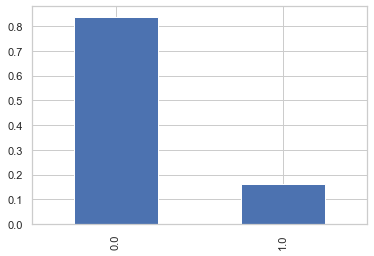

In [21]:
(y.value_counts()/len(y)).plot(kind='bar')
# 1과 0값이 매우 불균형을 이룸
# 이후 발란스 과정이 필요함

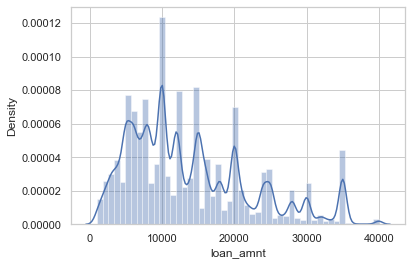

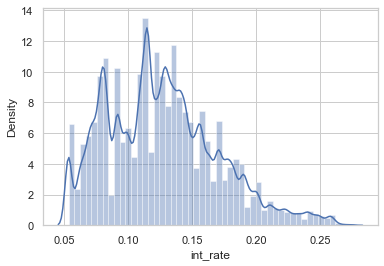

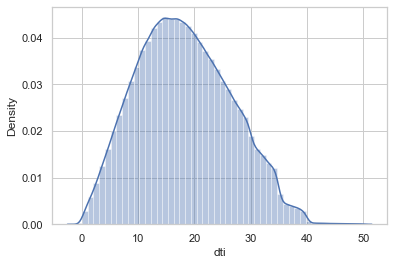

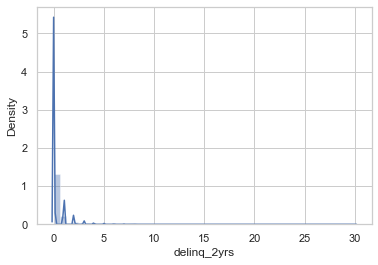

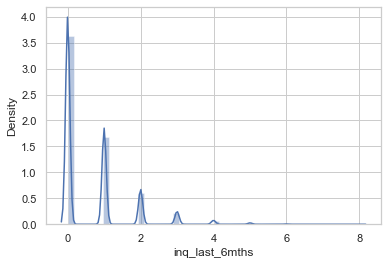

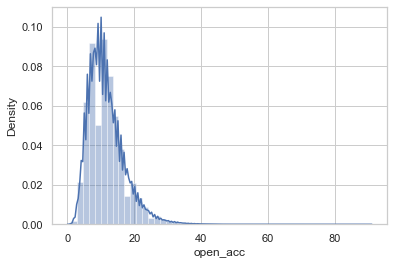

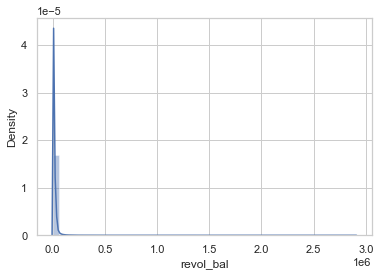

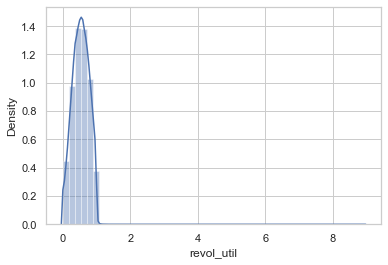

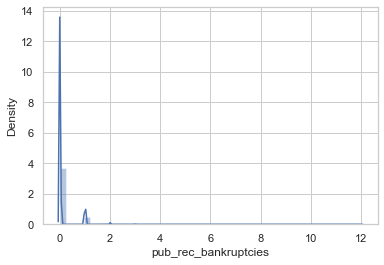

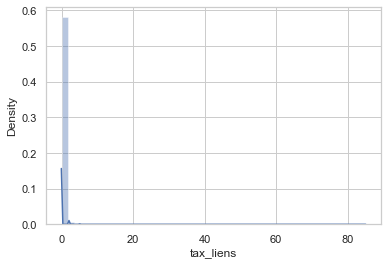

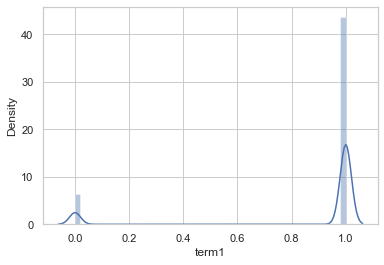

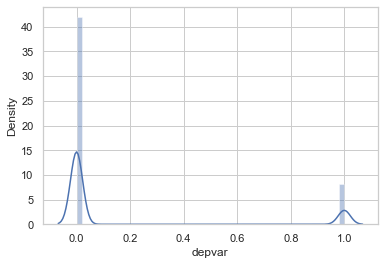

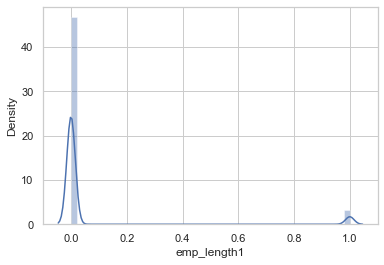

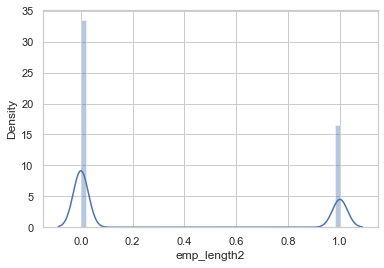

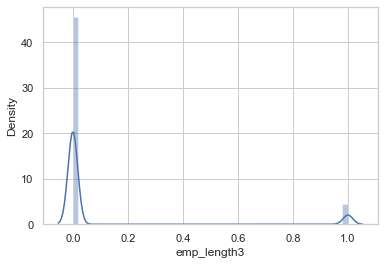

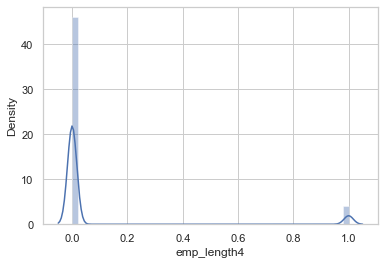

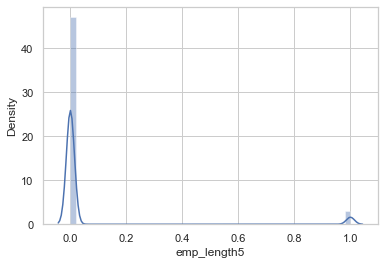

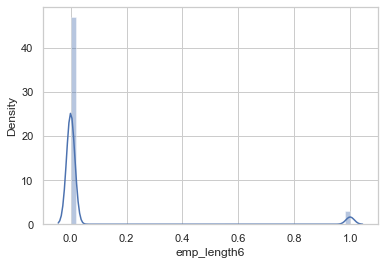

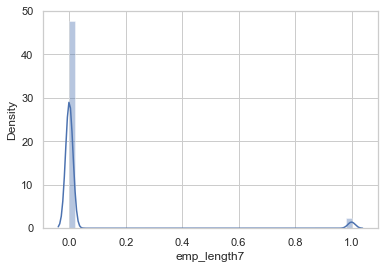

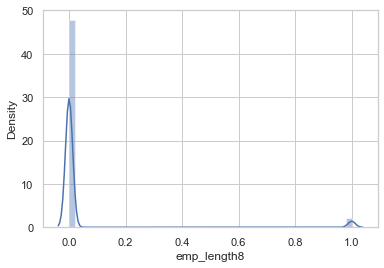

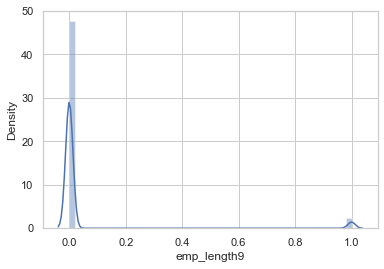

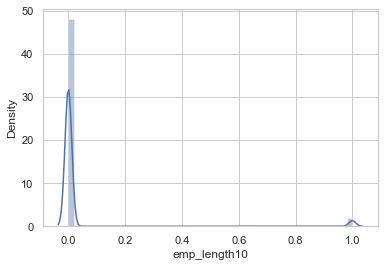

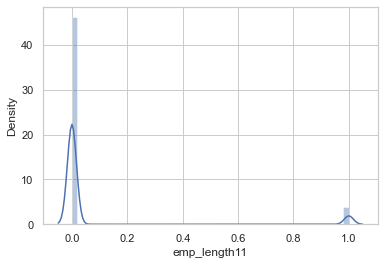

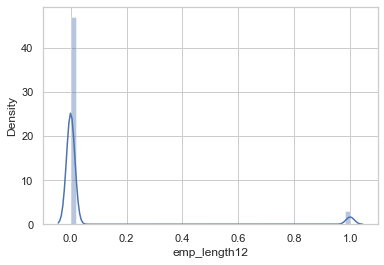

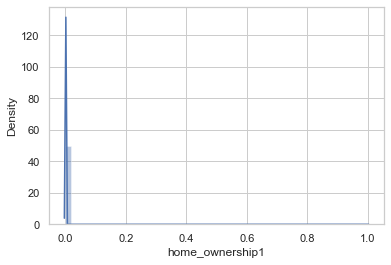

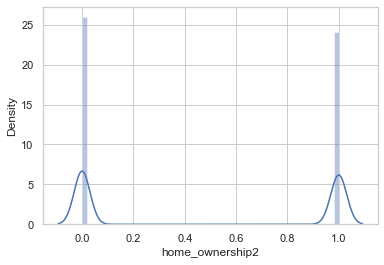

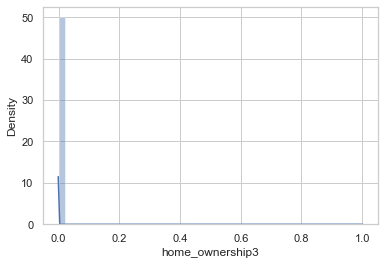

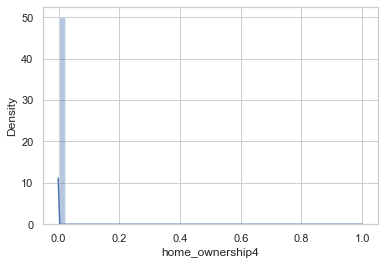

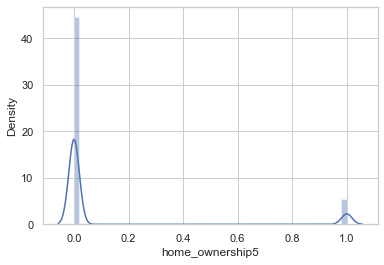

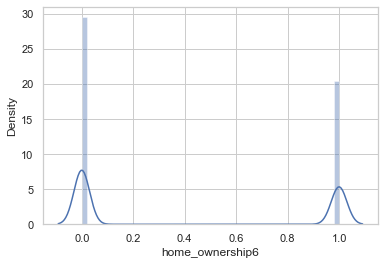

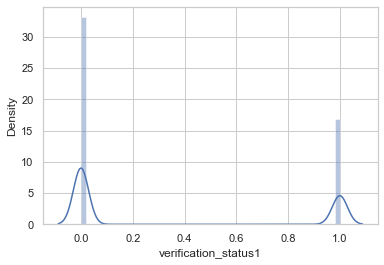

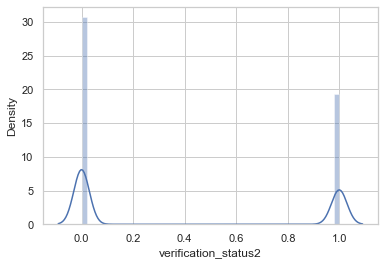

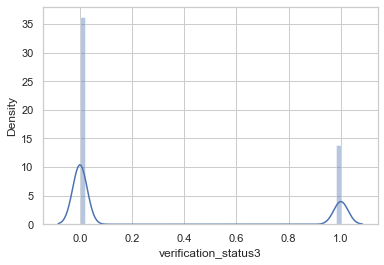

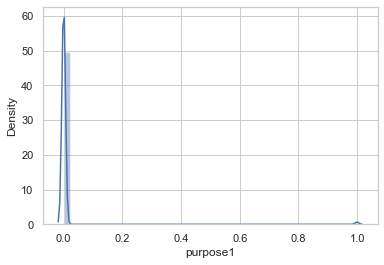

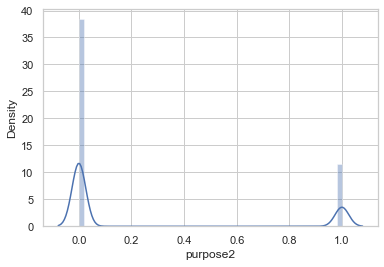

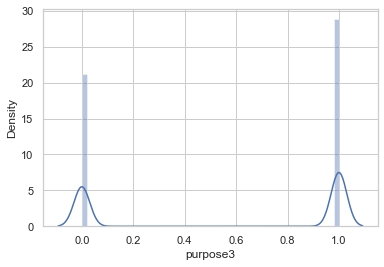

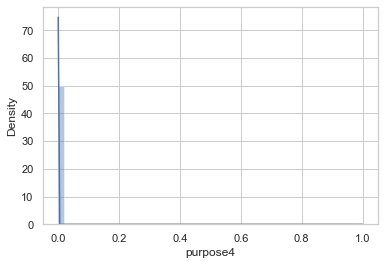

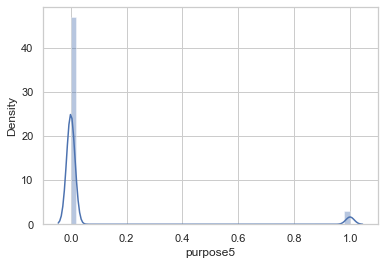

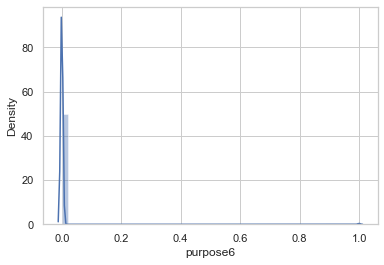

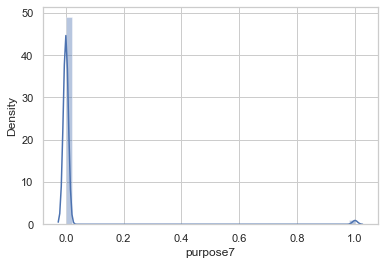

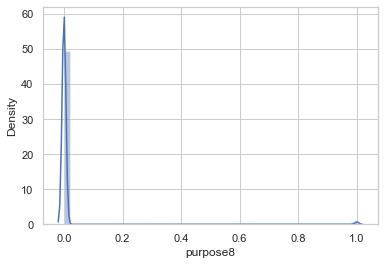

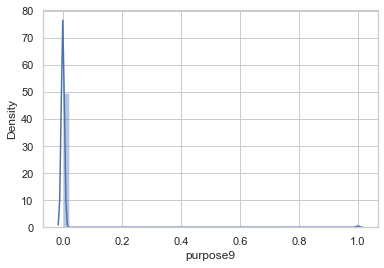

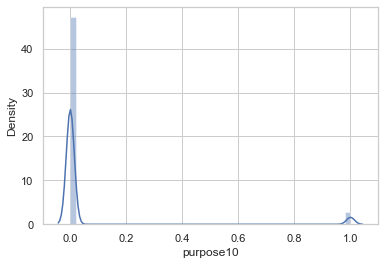

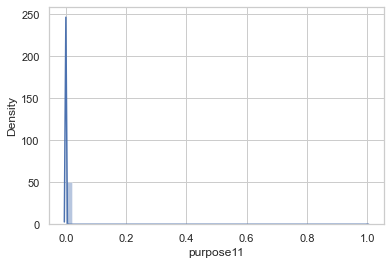

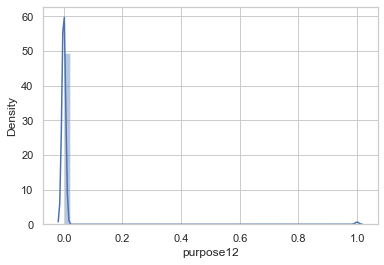

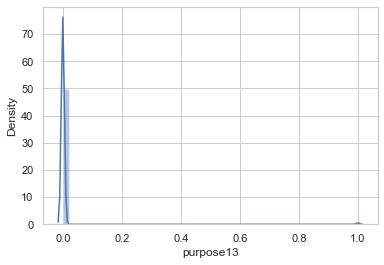

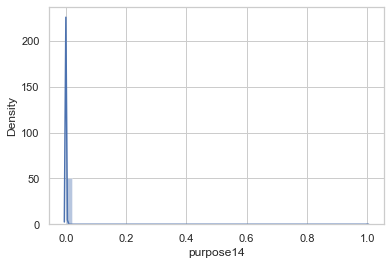

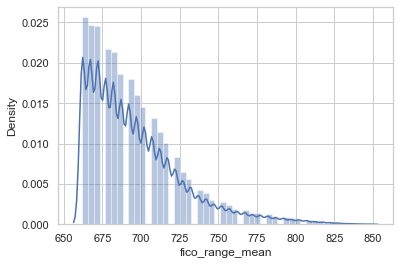

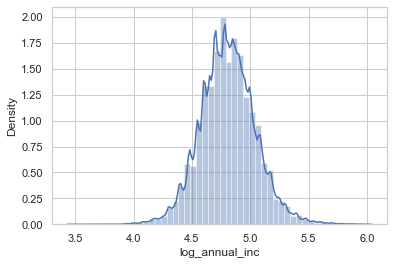

In [41]:
#설명변수 분포 그림으로
cols = LC.columns

for col in cols:
    fig,ax = plt.subplots(1,1)
    sns.distplot(LC[col])

### 2) 설명변수별 전처리

In [23]:
def plot_var(col_name, full_name, continuous):
    """
    Visualize a variable with and without faceting on the depvar.
    - col_name is the variable name in the dataframe
    - full_name is the full variable name
    - continuous is True if the variable is continuous, False otherwise
    """
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
    
    # Plot without depvar
    if continuous:
        sns.distplot(LC.loc[LC[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(LC[col_name], order=sorted(LC[col_name].unique()), color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(full_name)
    ax1.set_ylabel('Count')
    ax1.set_title(full_name)
        
    plt.tight_layout()

#### (1) loan_amnt

In [24]:
LC['loan_amnt'].describe()

count    1.092919e+06
mean     1.364630e+04
std      8.441163e+03
min      1.000000e+03
25%      7.125000e+03
50%      1.200000e+04
75%      1.900000e+04
max      4.000000e+04
Name: loan_amnt, dtype: float64

<AxesSubplot:xlabel='loan_amnt', ylabel='Density'>

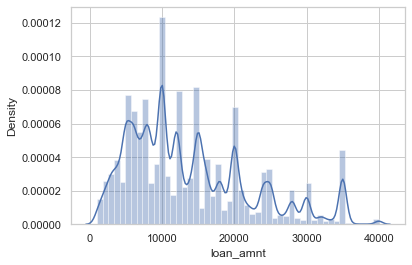

In [25]:
sns.distplot(X['loan_amnt'])

In [26]:
LC.groupby('depvar')['loan_amnt'].describe()

,count,mean,std,min,25%,50%,75%,max
depvar,,,,,,,,
0.0,916095.0,13554.392230,8427.131877,1000.0,7000.0,11700.0,18825.0,40000.0
1.0,176824.0,14122.470649,8497.606175,1000.0,7775.0,12000.0,20000.0,40000.0


#### (2) int_rate

In [27]:
print(LC['int_rate'].min())
print(LC['int_rate'].max())

0.053200000000000004
0.3099


<AxesSubplot:>

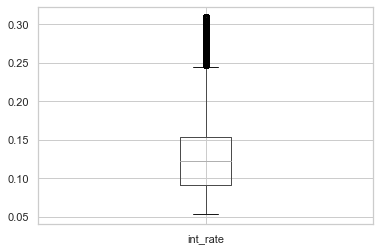

In [28]:
LC.boxplot(column='int_rate')

In [29]:
#이상치 제거
outlier_index = LC[LC['int_rate']>=0.275]
LC=LC.drop(outlier_index.index, axis=0)
print(df.shape)
print(LC.shape)

(1092919, 333)
(1091688, 49)


In [30]:
len(outlier_index)

1231

In [31]:
LC.groupby('depvar')['int_rate'].describe()

,count,mean,std,min,25%,50%,75%,max
depvar,,,,,,,,
0.0,915410.0,0.121978,0.041929,0.0532,0.0890,0.1167,0.1465,0.2749
1.0,176278.0,0.148156,0.043563,0.0532,0.1153,0.1446,0.1757,0.2749


#### (3) anual_inc

In [32]:
import numpy as np
#그래프 모양을 보았을 때, 이상치 제외만으로 잡을 수 없는 매우 불균형한 분포를 보이기 때문에 로그변환을 시행
LC['log_annual_inc'] = LC['annual_inc'].apply(lambda x: np.log10(x+1))
LC.drop('annual_inc', axis=1, inplace=True)
LC['log_annual_inc'].describe()

count    1.091688e+06
mean     4.809047e+00
std      2.355625e-01
min      3.477266e+00
25%      4.653222e+00
50%      4.806187e+00
75%      4.954247e+00
max      7.785330e+00
Name: log_annual_inc, dtype: float64

<AxesSubplot:>

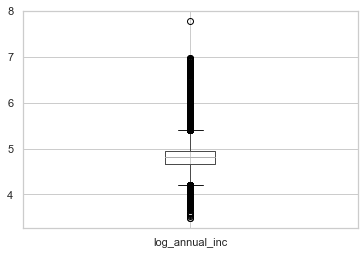

In [33]:
LC.boxplot(column='log_annual_inc')

In [34]:
#이상치 제거
outlier_index = LC[LC['log_annual_inc']>=6.000000e+00]
LC=LC.drop(outlier_index.index, axis=0)
print(df.shape)
print(LC.shape)

(1092919, 333)
(1091427, 49)


In [35]:
len(outlier_index)

261

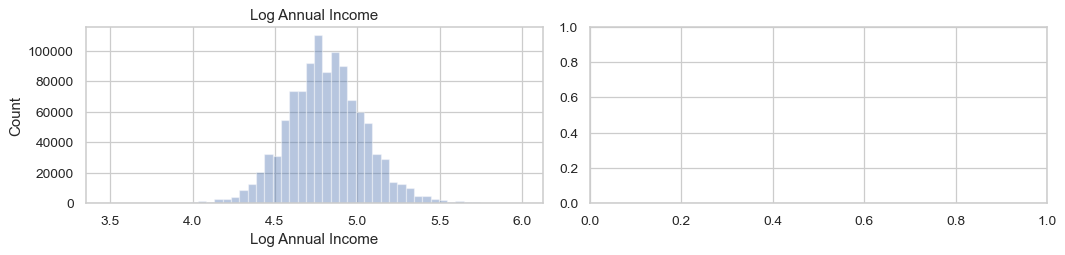

In [36]:
plot_var('log_annual_inc', 'Log Annual Income', continuous=True)

In [37]:
LC.groupby('depvar')['log_annual_inc'].describe()

,count,mean,std,min,25%,50%,75%,max
depvar,,,,,,,,
0.0,915182.0,4.816318,0.234620,3.477266,4.659831,4.812920,4.960476,5.999131
1.0,176245.0,4.769153,0.229762,3.602169,4.623260,4.774524,4.908490,5.992112


#### (4) dti

In [38]:
LC['dti'].describe()
#정규분포와 유사하므로 따로 처리x

count    1.091427e+06
mean     1.818008e+01
std      8.316384e+00
min     -1.000000e+00
25%      1.192000e+01
50%      1.767000e+01
75%      2.410000e+01
max      4.996000e+01
Name: dti, dtype: float64

<AxesSubplot:>

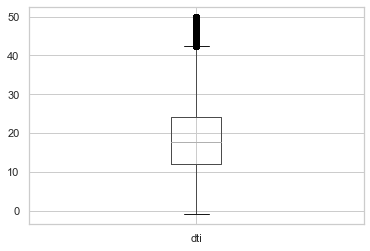

In [42]:
LC.boxplot(column='dti')

In [43]:
LC.groupby('depvar')['dti'].describe()

,count,mean,std,min,25%,50%,75%,max
depvar,,,,,,,,
0.0,915182.0,17.868022,8.249868,-1.0,11.65,17.31,23.68,49.96
1.0,176245.0,19.800490,8.470722,0.0,13.51,19.59,26.01,49.93


#### (5) delinq_2yrs

In [44]:
LC['delinq_2yrs'].describe()

count    1.091427e+06
mean     3.394473e-01
std      9.065505e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      3.000000e+01
Name: delinq_2yrs, dtype: float64

In [45]:
LC['delinq_2yrs'].value_counts()

0     869189
1     146028
2      43823
3      16130
4       7330
5       3711
6       2080
7       1153
8        672
9        421
10       296
11       174
12       123
13        91
14        72
15        46
16        27
18        20
17        13
19        10
20         8
21         4
22         3
29         1
24         1
30         1
Name: delinq_2yrs, dtype: int64

<AxesSubplot:xlabel='delinq_2yrs', ylabel='Density'>

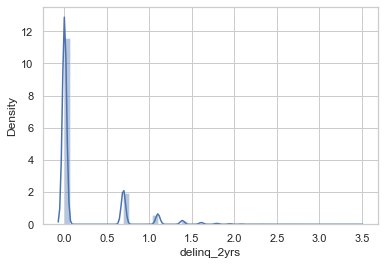

In [46]:
LC['delinq_2yrs'] = np.log1p(LC['delinq_2yrs'])
sns.distplot(LC['delinq_2yrs'])

In [47]:
LC['delinq_2yrs'].value_counts()

0.000000    869189
0.693359    146028
1.098633     43823
1.386719     16130
1.609375      7330
1.791992      3711
1.946289      2080
2.080078      1153
2.197266       672
2.302734       421
2.398438       296
2.484375       174
2.564453       123
2.638672        91
2.708984        72
2.773438        46
2.833984        27
2.945312        20
2.890625        13
2.996094        10
3.044922         8
3.091797         4
3.134766         3
3.218750         1
3.433594         1
3.400391         1
Name: delinq_2yrs, dtype: int64

In [48]:
LC.groupby('depvar')['delinq_2yrs'].describe()

,count,mean,std,min,25%,50%,75%,max
depvar,,,,,,,,
0.0,915182.0,NaN,0.000000,0.0,0.0,0.0,0.0,3.433594
1.0,176245.0,0.196289,0.411133,0.0,0.0,0.0,0.0,3.091797


#### (6) fico_range_mean

In [49]:
LC[['fico_range_mean']].describe()

,fico_range_mean
count,1.091427e+06
mean,6.962990e+02
std,3.061764e+01
min,6.620000e+02
25%,6.720000e+02
50%,6.870000e+02
75%,7.120000e+02
max,8.475000e+02


<AxesSubplot:xlabel='fico_range_mean', ylabel='Density'>

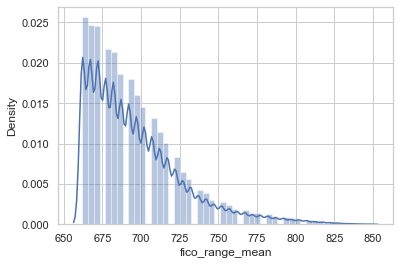

In [50]:
sns.distplot(LC['fico_range_mean'])

In [51]:
LC['fico_range_mean'].value_counts()
#800점 이상에서 부도날 확률 약 4%~그렇게 작은 수치는 아니므로 놔둠
#대신 로그로 스케일 조정을 취해줌

662.0    103850
667.0     99998
672.0     99538
677.0     88125
682.0     86288
687.0     75284
692.0     73008
697.0     65033
702.0     58978
707.0     53146
712.0     46099
717.0     40585
722.0     33658
727.0     26472
732.0     22727
737.0     17450
742.0     15537
747.0     12235
752.0     11192
757.0      9518
762.0      7736
767.0      7191
772.0      5887
777.0      5450
782.0      4971
787.0      4000
792.0      3631
797.0      2966
802.0      2697
807.0      2241
812.0      1656
817.0      1385
822.0      1006
827.0       763
832.0       501
837.0       296
842.0       186
847.5       143
Name: fico_range_mean, dtype: int64

In [52]:
LC['fico_range_mean'] = np.log1p(LC['fico_range_mean'])

In [53]:
LC.groupby('depvar')['fico_range_mean'].describe()

,count,mean,std,min,25%,50%,75%,max
depvar,,,,,,,,
0.0,915182.0,6.548512,0.043795,6.496775,6.511745,6.541030,6.569481,6.74347
1.0,176245.0,6.534718,0.034569,6.496775,6.511745,6.526495,6.555357,6.74347


#### (7)inq_last_6mths

In [54]:
LC['inq_last_6mths'].value_counts()

0    635204
1    293400
2    106767
3     39250
4     11831
5      4106
6       865
7         3
8         1
Name: inq_last_6mths, dtype: int64

In [55]:
LC.groupby('depvar')['inq_last_6mths'].describe()

,count,mean,std,min,25%,50%,75%,max
depvar,,,,,,,,
0.0,915182.0,0.609639,0.910708,0.0,0.0,0.0,1.0,8.0
1.0,176245.0,0.793362,1.029802,0.0,0.0,0.0,1.0,6.0


#### (8) open_acc

In [56]:
LC['open_acc'].value_counts()

9     97731
10    95394
8     93782
11    87504
7     84312
12    78283
6     69640
13    68036
14    57834
5     50743
15    48476
16    40644
17    33514
4     29696
18    27669
19    22556
20    18061
21    14417
3     12214
22    11764
23     9390
24     7548
25     6002
26     4518
27     3658
2      3053
28     2852
29     2304
30     1879
31     1420
32     1232
33     1023
34      773
35      623
36      476
37      394
38      317
39      277
1       263
40      201
41      168
42      158
43      105
44       90
45       79
46       59
47       40
49       38
48       33
52       27
51       25
50       24
53       19
54       14
56       10
55        9
57        8
58        7
59        5
60        5
63        4
61        3
65        3
76        2
62        2
66        2
67        2
84        1
82        1
80        1
79        1
77        1
86        1
75        1
74        1
71        1
70        1
69        1
64        1
90        1
Name: open_acc, dtype: int64

<AxesSubplot:>

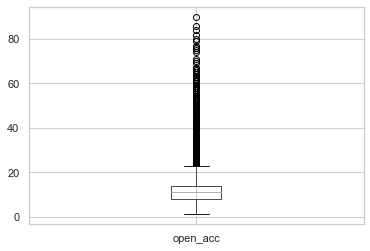

In [57]:
LC.boxplot(column='open_acc')

In [58]:
#이상치 제거(50이상일 때 부도인게 34개만 있음)
outlier_index = LC[LC['open_acc']>=50]
LC=LC.drop(outlier_index.index, axis=0)
print(df.shape)
print(LC.shape)

(1092919, 333)
(1091243, 49)


In [59]:
len(outlier_index)

184

In [60]:
LC.groupby('depvar')['open_acc'].describe()

,count,mean,std,min,25%,50%,75%,max
depvar,,,,,,,,
0.0,915034.0,11.528163,5.379283,1.0,8.0,11.0,14.0,49.0
1.0,176209.0,11.799851,5.481089,1.0,8.0,11.0,15.0,49.0


#### (9) revol_bal

In [61]:
LC['revol_bal'].describe()

count    1.091243e+06
mean     1.631905e+04
std      2.222978e+04
min      0.000000e+00
25%      6.057000e+03
50%      1.113600e+04
75%      1.975250e+04
max      2.904836e+06
Name: revol_bal, dtype: float64

In [62]:
LC['log_revol_bal'] = LC['revol_bal'].apply(lambda x: np.log10(x+1))
LC.drop('revol_bal', axis=1, inplace=True)

<AxesSubplot:>

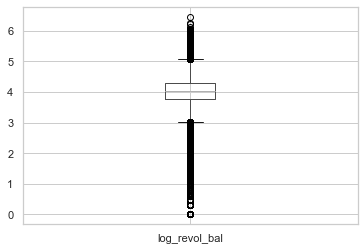

In [63]:
LC.boxplot(column='log_revol_bal')

In [64]:
LC['log_revol_bal'].value_counts()

0.000000    3046
3.736715      89
3.681513      86
3.718751      86
3.736556      84
3.791340      84
3.753736      84
3.719000      83
3.767453      83
3.770336      83
3.720159      83
3.709779      82
3.803321      82
3.729651      82
3.769894      82
3.740284      81
3.843233      81
3.720573      81
3.763278      81
3.758458      80
3.616686      80
3.802089      80
3.800786      80
3.543944      80
3.695394      80
3.774371      80
3.800236      80
3.657438      80
3.794070      80
3.685473      80
3.831358      79
3.784689      79
3.829432      79
3.646208      79
3.580355      79
3.739414      79
3.634175      79
3.778006      78
3.848004      78
3.874772      78
3.731428      78
3.788098      78
3.635886      78
3.813448      78
3.679246      78
3.789792      78
3.712650      78
3.825166      77
3.814913      77
3.745933      77
3.707485      77
3.767972      77
3.725258      77
3.721151      77
3.791129      77
3.968623      77
3.752509      77
3.700098      77
3.748498      

In [65]:
LC.groupby('depvar')['log_revol_bal'].describe()

,count,mean,std,min,25%,50%,75%,max
depvar,,,,,,,,
0.0,915034.0,4.013884,0.487062,0.0,3.785259,4.050766,4.301746,6.463122
1.0,176209.0,3.985365,0.465861,0.0,3.767601,4.026574,4.264346,6.242223


#### (10) revol_util

In [66]:
LC['revol_util'].describe()

count    1.091243e+06
mean     5.311710e-01
std      2.388556e-01
min      0.000000e+00
25%      3.530000e-01
50%      5.350000e-01
75%      7.150000e-01
max      8.923000e+00
Name: revol_util, dtype: float64

In [67]:
LC['revol_util'].value_counts()

0.000    3739
0.580    2240
0.530    2217
0.570    2205
0.610    2178
0.590    2157
0.480    2152
0.540    2152
0.620    2151
0.550    2150
0.600    2130
0.560    2111
0.510    2106
0.490    2090
0.470    2088
0.520    2086
0.500    2069
0.460    2069
0.440    2053
0.630    2046
0.430    2035
0.640    2016
0.650    2006
0.660    1994
0.450    1994
0.680    1990
0.420    1975
0.380    1960
0.410    1935
0.390    1928
0.670    1906
0.730    1905
0.400    1876
0.370    1872
0.720    1863
0.700    1857
0.690    1856
0.710    1836
0.360    1797
0.740    1796
0.330    1784
0.350    1767
0.750    1766
0.760    1753
0.340    1737
0.780    1720
0.770    1715
0.790    1672
0.310    1621
0.533    1612
0.320    1606
0.800    1604
0.562    1601
0.477    1600
0.543    1598
0.604    1589
0.542    1587
0.569    1586
0.578    1583
0.509    1582
0.547    1579
0.526    1573
0.491    1571
0.554    1571
0.484    1571
0.563    1570
0.467    1568
0.501    1563
0.541    1560
0.539    1559
0.552    1558
0.587 

In [68]:
LC.groupby('depvar')['revol_util'].describe()

,count,mean,std,min,25%,50%,75%,max
depvar,,,,,,,,
0.0,915034.0,0.526372,0.239746,0.0,0.347,0.529,0.711,8.923
1.0,176209.0,0.556089,0.232592,0.0,0.387,0.563,0.734,3.666


#### (11) pub_rec_bankruptcies

In [69]:
LC['pub_rec_bankruptcies'].value_counts().sort_index()

0     958070
1     124223
2       6875
3       1494
4        371
5        140
6         42
7         17
8          8
9          1
11         1
12         1
Name: pub_rec_bankruptcies, dtype: int64

In [70]:
LC.groupby('depvar')['pub_rec_bankruptcies'].describe()

,count,mean,std,min,25%,50%,75%,max
depvar,,,,,,,,
0.0,915034.0,0.128620,0.374344,0.0,0.0,0.0,0.0,12.0
1.0,176209.0,0.155577,0.413847,0.0,0.0,0.0,0.0,11.0


####  (12) tax_liens

In [71]:
LC['tax_liens'].value_counts().sort_index()
#10이후부터 부도 36개/ 9밑이168361임

0     1050861
1       27222
2        7566
3        2786
4        1254
5         683
6         365
7         180
8          93
9          64
10         48
11         30
12         19
13         11
14          8
15          9
16          6
17          7
18          4
19          1
20          2
21          4
22          2
23          1
24          2
27          3
30          1
34          1
37          1
39          1
45          1
46          1
48          1
53          1
61          2
63          1
85          1
Name: tax_liens, dtype: int64

In [72]:
#이상치 제거
outlier_index = LC[LC['tax_liens']>=10].index
print('이상치 index: ', outlier_index.values)

이상치 index:  [   4764    9675   13481   18762   31186   38933   42777   48725   52830
   63721   65590   73999   77107   84939   90201   90848   94244   94296
   94383  107518  112434  126086  138570  142170  142860  149001  159145
  163249  167073  168777  176188  181363  183724  183757  188188  192736
  195788  198427  199424  205244  206523  221234  227171  232466  235183
  239570  240758  245345  246485  249474  250340  253282  270614  287523
  292161  297218  304962  310925  311540  315147  324137  326068  326521
  327821  329324  329788  339887  348180  356836  367459  371564  376096
  377569  383879  385490  396741  416083  417597  456162  477058  549819
  551109  555856  556230  568102  577371  578395  579146  584262  590579
  595025  614362  630475  644063  650968  689391  735268  752548  757822
  765756  774192  777618  780876  781065  784536  788316  788904  798453
  803487  806646  808965  809802  809982  817513  820637  821101  822016
  826093  829091  841667  842097  84466

In [73]:
outlier_index = LC[LC['open_acc']>=50]
LC=LC.drop(outlier_index.index, axis=0)
print(df.shape)
print(LC.shape)

(1092919, 333)
(1091243, 49)


In [74]:
LC.groupby('depvar')['tax_liens'].describe()

,count,mean,std,min,25%,50%,75%,max
depvar,,,,,,,,
0.0,915034.0,0.059861,0.425211,0.0,0.0,0.0,0.0,63.0
1.0,176209.0,0.066932,0.507339,0.0,0.0,0.0,0.0,85.0


In [75]:
df.shape

(1092919, 333)

In [76]:
LC.shape

(1091243, 49)

In [77]:
X = LC.drop('depvar',axis=1)
y = LC['depvar']

In [78]:
LC.head()

,loan_amnt,int_rate,dti,delinq_2yrs,inq_last_6mths,open_acc,revol_util,pub_rec_bankruptcies,tax_liens,term1,depvar,emp_length1,emp_length2,emp_length3,emp_length4,emp_length5,emp_length6,emp_length7,emp_length8,emp_length9,emp_length10,emp_length11,emp_length12,home_ownership1,home_ownership2,home_ownership3,home_ownership4,home_ownership5,home_ownership6,verification_status1,verification_status2,verification_status3,purpose1,purpose2,purpose3,purpose4,purpose5,purpose6,purpose7,purpose8,purpose9,purpose10,purpose11,purpose12,purpose13,purpose14,fico_range_mean,log_annual_inc,log_revol_bal
0,19000,0.0916,16.36,0.693359,0,10,0.714,0,0,1,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,6.511745,4.812920,4.027146
1,10000,0.0789,5.03,0.000000,1,5,0.684,0,0,1,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,6.541030,4.763435,3.899875
2,6000,0.1147,24.23,1.098633,1,9,0.257,0,0,1,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,6.504288,4.671182,3.619302
3,25200,0.1199,32.87,0.000000,0,5,0.566,1,0,1,1.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,6.533789,4.882416,3.889638
4,8000,0.1299,20.28,0.000000,1,12,0.160,0,0,1,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,6.650279,4.462413,3.801061


In [79]:
LC.shape

(1091243, 49)

In [80]:
#종속변수 1열 처리
LC = LC[['depvar','loan_amnt', 'int_rate', 'log_annual_inc', 'dti', 'delinq_2yrs', 'fico_range_mean', 'inq_last_6mths',
        'open_acc', 'log_revol_bal', 'revol_util', 'pub_rec_bankruptcies',
       'tax_liens', 'emp_length1', 'emp_length2', 'emp_length3', 'emp_length4', 'emp_length5', 'emp_length6', 'emp_length7',
       'emp_length8', 'emp_length9', 'emp_length10', 'emp_length11', 'emp_length12', 'home_ownership1', 'home_ownership2',
       'home_ownership3', 'home_ownership4', 'home_ownership5', 'home_ownership6', 'verification_status1', 
        'verification_status2', 'verification_status3', 'purpose1', 'purpose2', 'purpose3','purpose4', 'purpose5',
          'purpose6','purpose7', 'purpose8', 'purpose9', 'purpose10', 'purpose11', 'purpose12', 'purpose13', 'purpose14', 'term1']]

In [81]:
X = LC.drop('depvar',axis=1)
y = LC['depvar']

In [82]:
LC.head()

,depvar,loan_amnt,int_rate,log_annual_inc,dti,delinq_2yrs,fico_range_mean,inq_last_6mths,open_acc,log_revol_bal,revol_util,pub_rec_bankruptcies,tax_liens,emp_length1,emp_length2,emp_length3,emp_length4,emp_length5,emp_length6,emp_length7,emp_length8,emp_length9,emp_length10,emp_length11,emp_length12,home_ownership1,home_ownership2,home_ownership3,home_ownership4,home_ownership5,home_ownership6,verification_status1,verification_status2,verification_status3,purpose1,purpose2,purpose3,purpose4,purpose5,purpose6,purpose7,purpose8,purpose9,purpose10,purpose11,purpose12,purpose13,purpose14,term1
0,0.0,19000,0.0916,4.812920,16.36,0.693359,6.511745,0,10,4.027146,0.714,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
1,0.0,10000,0.0789,4.763435,5.03,0.000000,6.541030,1,5,3.899875,0.684,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0.0,6000,0.1147,4.671182,24.23,1.098633,6.504288,1,9,3.619302,0.257,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
3,1.0,25200,0.1199,4.882416,32.87,0.000000,6.533789,0,5,3.889638,0.566,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
4,0.0,8000,0.1299,4.462413,20.28,0.000000,6.650279,1,12,3.801061,0.160,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1


#### 더미변수들은 제외

## 3. Statistics for Modeling

In [83]:
from sklearn.preprocessing import StandardScaler

#원본데이터 복사
LC_1=LC.copy() 

train = LC_1.drop('depvar',1)
test = LC_1['depvar']

# Train set과 Test set 8:2로 분할
X_train, X_test, y_train, y_test = train_test_split(train, test, test_size=0.2, random_state=1223)

# 더미변수를 제외한 일반 변수들 Standard Scaling
x_dummy_cols = ['emp_length1','emp_length2', 'emp_length3', 'emp_length4', 'emp_length5','emp_length6', 'emp_length7', 'emp_length8', 'emp_length9',
       'emp_length10', 'emp_length11', 'emp_length12', 'home_ownership1','home_ownership2', 'home_ownership3', 'home_ownership4',
       'home_ownership5', 'home_ownership6', 'verification_status1','verification_status2', 'verification_status3', 'purpose1',
        'purpose2','purpose3', 'purpose4', 'purpose5', 'purpose6', 'purpose7', 'purpose8','purpose9', 'purpose10', 'purpose11',
        'purpose12', 'purpose13','purpose14']
x_cols = ['loan_amnt', 'int_rate', 'log_annual_inc', 'dti', 'delinq_2yrs','inq_last_6mths', 'open_acc', 'log_revol_bal', 'revol_util',
       'pub_rec_bankruptcies', 'tax_liens', 'term1','fico_range_mean']
y_col = ['depvar']

def scaler(df, opt='standard'):
    if opt=='standard':
        scale = StandardScaler()
    elif opt=='minmax':
        scale = StandardScaler()    
    scale.fit(df)
    return scale.transform(df)

X_train[x_cols] = scaler(X_train[x_cols], opt='standard')
X_test[x_cols] = scaler(X_test[x_cols], opt='standard')

In [84]:
target = LC_1['depvar']
target.value_counts()

0.0    915034
1.0    176209
Name: depvar, dtype: int64

<AxesSubplot:>

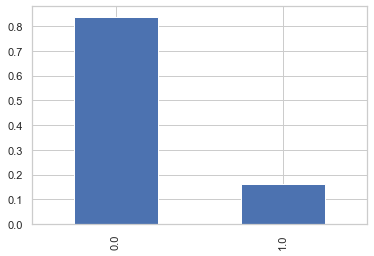

In [85]:
(LC_1.depvar.value_counts()/len(LC_1)).plot(kind='bar')

In [86]:
LC_1 = LC.copy()
LC_1['depvar'] = LC_1['depvar'].astype('float64')

In [87]:
X_train, X_test, y_train, y_test = train_test_split(train, test, test_size=0.2, random_state=1223)

x_dummy_cols = ['emp_length1','emp_length2', 'emp_length3', 'emp_length4', 'emp_length5','emp_length6', 'emp_length7', 'emp_length8', 'emp_length9',
       'emp_length10', 'emp_length11', 'emp_length12', 'home_ownership1','home_ownership2', 'home_ownership3', 'home_ownership4',
       'home_ownership5', 'home_ownership6', 'verification_status1','verification_status2', 'verification_status3', 'purpose1',
        'purpose2','purpose3', 'purpose4', 'purpose5', 'purpose6', 'purpose7', 'purpose8','purpose9', 'purpose10', 'purpose11',
        'purpose12', 'purpose13','purpose14']
x_cols = ['loan_amnt', 'int_rate', 'log_annual_inc', 'dti', 'delinq_2yrs','inq_last_6mths', 'open_acc', 'log_revol_bal', 'revol_util',
       'pub_rec_bankruptcies', 'tax_liens', 'term1','fico_range_mean']
y_col = ['depvar']

def scaler(df, opt='standard'):
    if opt=='standard':
        scale = StandardScaler()
    elif opt=='minmax':
        scale = StandardScaler()    
    scale.fit(df)
    return scale.transform(df)

# 분할한 Train set에서 Validation set 분할. 최종 Train, Validation, Test set 비율 = 6:2:2
X_train[x_cols] = scaler(X_train[x_cols], opt='standard')
X_test[x_cols] = scaler(X_test[x_cols], opt='standard')

X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.25, random_state=1223)

In [88]:
# Train set을 SMOTE를 통해 Oversampling
from imblearn.over_sampling import SMOTE 
sm= SMOTE(random_state=156)
X_sm, y_sm = sm.fit_sample(X_train, y_train)

print('SMOTE 적용 전 학습용 피처/레이블 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 세트: ', X_sm.shape, y_sm.shape)
print('SMOTE 적용 후 레이블 값 분포: \n',pd.Series(y_sm).value_counts())

SMOTE 적용 전 학습용 피처/레이블 세트:  (654745, 48) (654745,)
SMOTE 적용 후 학습용 피처/레이블 세트:  (1097888, 48) (1097888,)
SMOTE 적용 후 레이블 값 분포: 
 1.0    548944
0.0    548944
Name: depvar, dtype: int64


## 3.1 Logistic Regression 

In [89]:
lr_bs = LogisticRegression()
lr_bs.fit(X_sm, y_sm)

LogisticRegression()

In [90]:
# 절편과 각 변수별 계수 확인
print(lr_bs.intercept_)
print(lr_bs.coef_)

[27.30467133]
[[  0.11668428   0.39590643  -0.22046584   0.14797503  -0.13300534
   -0.35992404  -0.01772663   0.01236571  -0.01139106  -0.02942037
   -0.11495493  -0.12522829 -10.61737205 -10.25523972 -10.55497424
  -10.55670843 -10.68380431 -10.65713596 -10.72291152 -10.70192272
  -10.68123697 -10.72580291 -10.57688634 -10.09022993  -3.99300915
   -5.57187358  -0.50981744  -0.48942315  -5.80879581  -5.27504807
   -6.74943405  -6.60326515  -6.74513184  -6.50334574  -5.48910843
   -5.23513434   0.          -5.72107859  -6.34441332  -6.09282287
   -6.05052391  -6.06837813  -5.87147257  -6.22724261  -5.84276833
   -5.91533762  -7.58245834  -0.07127352]]


In [91]:
# Train set에 대한 모델의 예측 확률 분포
lr_bs.predict_proba(X_sm)[:,1]

array([0.30093535, 0.13409099, 0.2936083 , ..., 0.4628884 , 0.999943  ,
       0.99603474])

In [92]:
#logit 결과를 Validation set에 predict해서 result에 저장 
result_2 = pd.DataFrame(lr_bs.predict_proba(X_val)[:,1])

<AxesSubplot:ylabel='Frequency'>

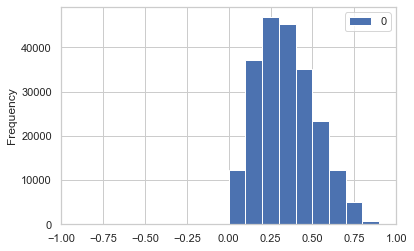

In [93]:
result_2.plot(kind='hist',bins=10, xlim=([-1,1]))

In [94]:
fpr_2,tpr_2,thresholds_2=roc_curve(y_val, result_2)

In [95]:
fpr_2

array([0.00000000e+00, 5.46143679e-06, 7.09986783e-05, ...,
       9.99972693e-01, 9.99972693e-01, 1.00000000e+00])

In [96]:
tpr_2

array([0.        , 0.        , 0.        , ..., 0.99997155, 1.        ,
       1.        ])

In [97]:
thresholds_2

array([1.99822688e+00, 9.98226884e-01, 9.47313448e-01, ...,
       2.42002916e-03, 2.31257166e-03, 1.63060361e-08])

In [98]:
fpr_bs,tpr_bs,thresholds_bs = roc_curve(y_val, result_2)

In [99]:
#auc 구하기
roc_auc_bs = auc(fpr_bs, tpr_bs)
roc_auc_bs

0.6558364976530163

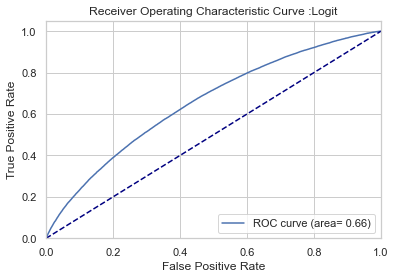

In [100]:
# ROC Curve 그리기
plt.figure()
plt.plot(fpr_bs, tpr_bs, label='ROC curve (area= %0.2f)' % roc_auc_bs)

##그래프에 직선 추가하기
plt.plot([0,1],[0,1],color='navy', linestyle='--')

#x축과 y축 구간 설정하기
plt.xlim([0,1])
plt.ylim([0,1.05])

#축 이름 및 그래프 타이틀, 레전드 추가하기
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve :Logit')
plt.legend(loc="lower right")

plt.show()

In [101]:
#fpr, tpr, threshold 로 구성된 dataframe 생성하기
roc_result_2 = pd.DataFrame([fpr_bs,tpr_bs,thresholds_bs], index=['fpr','tpr','thresholds']).T
# (1-fpr)+(tpr)값을 계산하여 'best'라는 이름의 칼럼 생성하기
roc_result_2['best'] = (1-roc_result_2.fpr)+(roc_result_2.tpr) # specificity + sensitivity
# 'best'가 가장 클 때의 Threshold를 최적 임계치로 설정
roc_result_2.tail(20)

,fpr,tpr,thresholds,best
56221,0.998023,0.999744,2.627101e-02,1.001721
56222,0.998722,0.999744,2.287824e-02,1.001022
56223,0.998722,0.999772,2.287748e-02,1.001050
56224,0.999099,0.999772,2.079014e-02,1.000674
56225,0.999099,0.999801,2.078600e-02,1.000702
56226,0.999252,0.999801,1.901452e-02,1.000549
56227,0.999252,0.999829,1.900437e-02,1.000578
56228,0.999416,0.999829,1.785451e-02,1.000414
56229,0.999416,0.999858,1.772199e-02,1.000442
56230,0.999650,0.999858,1.543898e-02,1.000207


In [102]:
#최적 threshold는 best의 값이 최대가 될 때의 threshold 값
optimal_threshold_2=roc_result_2.thresholds[roc_result_2.best.idxmax()] 
#roc_result.best.idxmax()는 best값이 max 일때의 index를 의미
optimal_threshold_2

0.3432419453058005

In [103]:
# Confusion Matrix
#각 모형 별로 optimal threshold를 이용하여 binary (0 or 1) 로 예측
c = np.where(result_2>=optimal_threshold_2,1,0)
c

array([[0],
       [1],
       [0],
       ...,
       [1],
       [0],
       [1]])

In [104]:
logit_con_2 = confusion_matrix(y_test,c)
logit_con_2

array([[97893, 85095],
       [18912, 16349]], dtype=int64)

In [105]:
tn_2, fp_2, fn_2, tp_2 = confusion_matrix(y_test, c).ravel()
(tn_2, fp_2, fn_2, tp_2)

(97893, 85095, 18912, 16349)

In [106]:
tp_2/(tp_2+fn_2) # tpr = sensitivity

0.46365673123280676

In [107]:
fp_2/(tn_2+fp_2) # fpr = 1-specificity

0.4650304938028723

In [108]:
(tn_2+tp_2)/(tn_2+fp_2+fn_2+tp_2) # accuracy

0.5234479883069338

## 3.2 Decision Tree

In [130]:
#결정트리 모델 import
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore')

In [132]:
# Decision Tree Model에 Train set fit
dt_clf = DecisionTreeClassifier(random_state=1213)
dt_clf.fit(X_sm,y_sm)
# Fit한 모델을 통해 Validation Set 예측
pred=dt_clf.predict(X_val)
pred_proba = dt_clf.predict_proba(X_val)

In [134]:
# Decision Tree 결과를 validation set에 predict해서 result에 저장 
result = pd.DataFrame(dt_clf.predict_proba(X_val)[:,1])

In [135]:
fpr,tpr,thresholds=roc_curve(y_val, result)

In [136]:
fpr

array([0.        , 0.18077902, 1.        ])

In [137]:
tpr

array([0.        , 0.25157197, 1.        ])

In [138]:
thresholds

array([2., 1., 0.])

In [139]:
fpr_dt,tpr_dt,thresholds_dt = roc_curve(y_val, result)

In [140]:
#auc 구하기
roc_auc_dt = auc(fpr_dt, tpr_dt)
roc_auc_dt

0.535396474906849

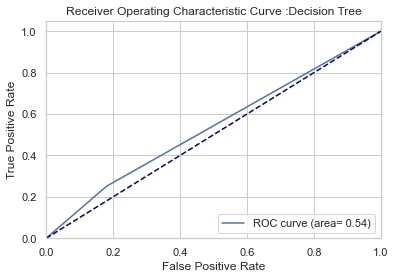

In [142]:
# ROC Curve 그리기
plt.figure()
plt.plot(fpr_dt, tpr_dt, label='ROC curve (area= %0.2f)' % roc_auc_dt)

##그래프에 직선 추가하기
plt.plot([0,1],[0,1],color='navy', linestyle='--')

#x축과 y축 구간 설정하기
plt.xlim([0,1])
plt.ylim([0,1.05])

#축 이름 및 그래프 타이틀, 레전드 추가하기
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve :Decision Tree')
plt.legend(loc="lower right")

plt.show()

In [143]:
#fpr, tpr, threshold 로 구성된 dataframe 생성하기
roc_result = pd.DataFrame([fpr,tpr,thresholds], index=['fpr','tpr','thresholds']).T
# (1-fpr)+(tpr)값을 계산하여 'best'라는 이름의 칼럼 생성하기
roc_result['best'] = (1-roc_result.fpr)+(roc_result.tpr) # specificity + sensitivity
#'best'가 최대가 될 때의 임계치를 최적 임계치로 설정
roc_result.tail(20)

,fpr,tpr,thresholds,best
0,0.000000,0.000000,2.0,1.000000
1,0.180779,0.251572,1.0,1.070793
2,1.000000,1.000000,0.0,1.000000


In [144]:
#최적 threshold는 best의 값이 최대가 될 때의 threshold 값
optimal_threshold=roc_result.thresholds[roc_result.best.idxmax()] 
#roc_result.best.idxmax()는 best값이 max 일때의 index를 의미
optimal_threshold

1.0

In [145]:
# Confusion Matrix
#각 모형 별로 optimal threshold를 이용하여 binary (0 or 1) 로 예측
result.values
a = np.where(result>=optimal_threshold,1,0)
a

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [146]:
dt_con = confusion_matrix(y_test,a)

In [147]:
tn, fp, fn, tp = confusion_matrix(y_test, a).ravel()
(tn, fp, fn, tp)

(147871, 35117, 28435, 6826)

In [148]:
tp/(tp+fn) # tpr = sensitivity

0.19358498057343806

## 3.3 Random Forest

In [109]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_jobs=-1, random_state=1)

In [110]:
rfc.fit(X_sm, y_sm)

RandomForestClassifier(n_jobs=-1, random_state=1)

In [111]:
rfc.predict_proba(X_sm)[:,1]

array([0.19, 0.08, 0.04, ..., 0.98, 0.93, 0.99])

In [112]:
#Random Forest 결과를 validation set에 predict해서 result에 저장 
result_3 = pd.DataFrame(rfc.predict_proba(X_val)[:,1])

<AxesSubplot:ylabel='Frequency'>

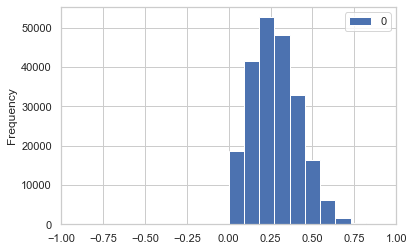

In [113]:
result_3.plot(kind='hist',bins=10, xlim=([-1,1]))

In [114]:
fpr_3,tpr_3,thresholds_3=roc_curve(y_val, result_3)

In [115]:
fpr_3

array([0.00000000e+00, 5.46143679e-06, 1.09228736e-05, 1.09228736e-05,
       1.63843104e-05, 2.73071840e-05, 3.82300576e-05, 6.00758047e-05,
       7.64601151e-05, 1.14690173e-04, 1.85688851e-04, 2.40303219e-04,
       3.27686208e-04, 4.09607760e-04, 5.07913622e-04, 6.60833852e-04,
       8.35599830e-04, 1.10321023e-03, 1.39266638e-03, 1.77496696e-03,
       2.22280478e-03, 2.77440989e-03, 3.38062938e-03, 4.06330898e-03,
       4.86067875e-03, 5.88742886e-03, 6.91964042e-03, 8.26861531e-03,
       9.92889209e-03, 1.17147819e-02, 1.38228965e-02, 1.62532359e-02,
       1.89238785e-02, 2.19877445e-02, 2.54011425e-02, 2.96119103e-02,
       3.41175957e-02, 3.89236600e-02, 4.46472458e-02, 5.08951295e-02,
       5.78693843e-02, 6.54116285e-02, 7.37621654e-02, 8.35818287e-02,
       9.37728698e-02, 1.04903278e-01, 1.16672674e-01, 1.29687278e-01,
       1.43351793e-01, 1.58747583e-01, 1.75093664e-01, 1.92652183e-01,
       2.11466833e-01, 2.31313694e-01, 2.51466396e-01, 2.72826075e-01,
      

In [116]:
tpr_3

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.69038609e-05,
       1.13807722e-04, 1.70711583e-04, 2.56067374e-04, 3.69875096e-04,
       3.98327026e-04, 4.55230887e-04, 7.39750192e-04, 8.82009844e-04,
       1.16652915e-03, 1.36569266e-03, 1.70711583e-03, 2.38996216e-03,
       3.30042393e-03, 3.69875096e-03, 4.80837625e-03, 5.91800154e-03,
       6.88536717e-03, 8.27951176e-03, 9.98662759e-03, 1.16083876e-02,
       1.36569266e-02, 1.64452158e-02, 1.92904089e-02, 2.22778616e-02,
       2.63180357e-02, 3.07565368e-02, 3.63046633e-02, 4.17674339e-02,
       4.80553106e-02, 5.51113893e-02, 6.43582667e-02, 7.32352690e-02,
       8.36202236e-02, 9.53708709e-02, 1.07804365e-01, 1.21205224e-01,
       1.36540814e-01, 1.51307366e-01, 1.68719948e-01, 1.87754289e-01,
       2.05935073e-01, 2.26448915e-01, 2.47844766e-01, 2.71346061e-01,
       2.94648192e-01, 3.19628987e-01, 3.45861667e-01, 3.71980539e-01,
       4.00261758e-01, 4.27888582e-01, 4.54576493e-01, 4.82857712e-01,
      

In [117]:
thresholds_3

array([1.91, 0.91, 0.88, 0.87, 0.86, 0.85, 0.84, 0.83, 0.82, 0.81, 0.8 ,
       0.79, 0.78, 0.77, 0.76, 0.75, 0.74, 0.73, 0.72, 0.71, 0.7 , 0.69,
       0.68, 0.67, 0.66, 0.65, 0.64, 0.63, 0.62, 0.61, 0.6 , 0.59, 0.58,
       0.57, 0.56, 0.55, 0.54, 0.53, 0.52, 0.51, 0.5 , 0.49, 0.48, 0.47,
       0.46, 0.45, 0.44, 0.43, 0.42, 0.41, 0.4 , 0.39, 0.38, 0.37, 0.36,
       0.35, 0.34, 0.33, 0.32, 0.31, 0.3 , 0.29, 0.28, 0.27, 0.26, 0.25,
       0.24, 0.23, 0.22, 0.21, 0.2 , 0.19, 0.18, 0.17, 0.16, 0.15, 0.14,
       0.13, 0.12, 0.11, 0.1 , 0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03,
       0.02, 0.01, 0.  ])

In [118]:
fpr_rfc,tpr_rfc,thresholds_rfc = roc_curve(y_val, result_3)

In [119]:
#auc 구하기
roc_auc_rfc = auc(fpr_rfc, tpr_rfc)
roc_auc_rfc

0.6630073955530389

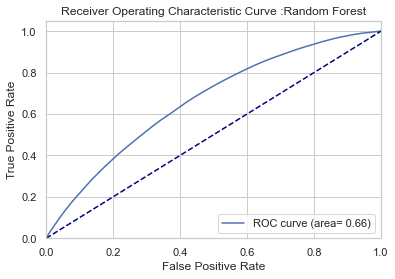

In [120]:
# ROC Curve 그리기
plt.figure()
plt.plot(fpr_rfc, tpr_rfc, label='ROC curve (area= %0.2f)' % roc_auc_rfc)

##그래프에 직선 추가하기
plt.plot([0,1],[0,1],color='navy', linestyle='--')

#x축과 y축 구간 설정하기
plt.xlim([0,1])
plt.ylim([0,1.05])

#축 이름 및 그래프 타이틀, 레전드 추가하기
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve :Random Forest')
plt.legend(loc="lower right")

plt.show()

In [121]:
#fpr, tpr, threshold 로 구성된 dataframe 생성하기
roc_result_3 = pd.DataFrame([fpr_rfc,tpr_rfc,thresholds_rfc], index=['fpr','tpr','thresholds']).T
# (1-fpr)+(tpr)값을 계산하여 'best'라는 이름의 칼럼 생성하기
roc_result_3['best'] = (1-roc_result_3.fpr)+(roc_result_3.tpr) # specificity + sensitivity
# 'best'가 최대가 될 때의 threshold를 최적 임계치로 설정
roc_result_3.tail(20)

,fpr,tpr,thresholds,best
71,0.694520,0.881014,0.19,1.186494
72,0.720921,0.896350,0.18,1.175429
73,0.747769,0.911571,0.17,1.163802
74,0.772853,0.924318,0.16,1.151464
75,0.798009,0.936410,0.15,1.138401
76,0.821553,0.947905,0.14,1.126352
77,0.843765,0.957635,0.13,1.113870
78,0.865048,0.966427,0.12,1.101379
79,0.884480,0.973284,0.11,1.088804
80,0.902524,0.978889,0.10,1.076364


In [122]:
#최적 threshold는 best의 값이 최대가 될 때의 threshold 값
optimal_threshold_3=roc_result_3.thresholds[roc_result_3.best.idxmax()] 
#roc_result.best.idxmax()는 best값이 max 일때의 index를 의미
optimal_threshold_3

0.28

In [123]:
# Confusion Matrix
#각 모형 별로 optimal threshold를 이용하여 binary (0 or 1) 로 예측
d = np.where(result_3>=optimal_threshold_3,1,0)
d

array([[0],
       [1],
       [1],
       ...,
       [1],
       [0],
       [1]])

In [124]:
rfc_con_3 = confusion_matrix(y_test,d)
rfc_con_3

array([[94452, 88536],
       [18291, 16970]], dtype=int64)

In [125]:
tn_3, fp_3, fn_3, tp_3 = confusion_matrix(y_test, d).ravel()
(tn_3, fp_3, fn_3, tp_3)

(94452, 88536, 18291, 16970)

In [126]:
tp_3/(tp_3+fn_3) # tpr = sensitivity

0.48126825671421686

In [127]:
fp_3/(tn_3+fp_3) # fpr = 1-specificity

0.483835005574136

In [128]:
(tn_3+tp_3)/(tn_3+fp_3+fn_3+tp_3) # accuracy

0.510526966904774